# Algoritmos de optimización - Trabajo Práctico

**IMPORTANTE**
**Poner el excel exportado a csv llamado "datos_proyecto.csv" **

Nombre y Apellidos: Victor Callejas Fuentes

Url: https://github.com/VictorCallejas/03miar

Google Colab: https://colab.research.google.com/drive/171ogmOaMQpb7Eqij9xkg_c2NOzauksXY?usp=sharing


Problema:
Sesiones de doblaje


Descripción del problema:(copiar enunciado)

Se precisa coordinar el doblaje de una película. Los actores del doblaje deben coincidir en
las tomas en las que sus personajes aparecen juntos en las diferentes tomas. Los actores de
doblaje cobran todos la misma cantidad por cada día que deben desplazarse hasta el
estudio de grabación independientemente del número de tomas que se graben. No es
posible grabar más de 6 tomas por día. El objetivo es planificar las sesiones por día de
manera que el gasto por los servicios de los actores de doblaje sea el menor posible. Los
datos son:

Número de actores: 10

Número de tomas : 30

Actores/Tomas : https://bit.ly/36D8IuK (archivo datos_proyecto.csv)

- 1 indica que el actor participa en la toma
- 0 en caso contrario
                                        

In [4]:
# Imports comunes
import math
import random
import pandas as pd
import matplotlib.pyplot as plt

random.seed(42)

# Modelo
- ¿Como represento el espacio de soluciones?
- ¿Cual es la función objetivo?
- ¿Como implemento las restricciones?

In [5]:
# ----------------------------
# 1) Carga y preparación de datos
# ----------------------------
df = pd.read_csv("datos_proyecto.csv", skiprows=1) # Excel del profesor exportado a csv
df = df.iloc[:30].copy()
df["Toma"] = df["Toma"].astype(int)

actor_cols = [str(i) for i in range(1, 11)]
for c in actor_cols:
    df[c] = df[c].astype(int)

df = df.sort_values("Toma").reset_index(drop=True)

# toma -> conjunto de actores que participan
tomas_actores = {
    int(row["Toma"]): {i for i, c in enumerate(actor_cols, start=1) if row[c] == 1}
    for _, row in df.iterrows()
}

TOMAS = list(tomas_actores.keys())
NUM_TOMAS = len(TOMAS)
NUM_ACTORES = len(actor_cols)
NUM_DIAS = 5
MAX_TOMAS_DIA = 6

# ----------------------------
# 2) Modelo
# ----------------------------
# Espacio de soluciones:
#   Asignar cada toma a un día entre 0..4, con máximo 6 tomas por día.
# Función objetivo:
#   Minimizar actor-días = suma de actores únicos presentes cada día.
# Restricciones:
#   - Todas las tomas se asignan exactamente una vez
#   - Cada día tiene <= 6 tomas

def es_factible(plan):
    if set(plan.keys()) != set(range(NUM_DIAS)):
        return False

    todas = []
    for d in range(NUM_DIAS):
        tomas_d = plan[d]
        if len(tomas_d) > MAX_TOMAS_DIA:
            return False
        todas.extend(tomas_d)

    return sorted(todas) == sorted(TOMAS)


def coste_actor_dias(plan):
    total = 0
    for d in range(NUM_DIAS):
        presentes = set()
        for t in plan[d]:
            presentes |= tomas_actores[t]
        total += len(presentes)
    return total


def plan_base_orden_natural():
    plan = {d: [] for d in range(NUM_DIAS)}
    for i, t in enumerate(TOMAS):
        plan[i // MAX_TOMAS_DIA].append(t)
    return plan


def copiar_plan(plan):
    return {d: list(plan[d]) for d in range(NUM_DIAS)}


def generar_vecino_swap(plan):
    vecino = copiar_plan(plan)
    d1, d2 = random.sample(range(NUM_DIAS), 2)
    i = random.randrange(len(vecino[d1]))
    j = random.randrange(len(vecino[d2]))
    vecino[d1][i], vecino[d2][j] = vecino[d2][j], vecino[d1][i]
    return vecino


def recocido_simulado(temp_ini=20.0, temp_fin=0.05, alpha=0.95, iter_por_temp=250):
    actual = plan_base_orden_natural()
    coste_actual = coste_actor_dias(actual)

    mejor = copiar_plan(actual)
    mejor_coste = coste_actual

    historial_mejor = [mejor_coste]

    T = temp_ini
    while T > temp_fin:
        for _ in range(iter_por_temp):
            cand = generar_vecino_swap(actual)
            coste_cand = coste_actor_dias(cand)
            delta = coste_cand - coste_actual

            if delta <= 0 or random.random() < math.exp(-delta / T):
                actual = cand
                coste_actual = coste_cand

                if coste_actual < mejor_coste:
                    mejor = copiar_plan(actual)
                    mejor_coste = coste_actual

            historial_mejor.append(mejor_coste)

        T *= alpha

    return mejor, mejor_coste, historial_mejor


def resumen_plan(plan):
    filas = []
    for d in range(NUM_DIAS):
        tomas_d = sorted(plan[d])
        actores_d = set()
        for t in tomas_d:
            actores_d |= tomas_actores[t]
        filas.append({
            "dia": d + 1,
            "tomas": tomas_d,
            "num_tomas": len(tomas_d),
            "num_actores": len(actores_d),
        })
    return filas


# ----------------------------
# 3) Comparación baseline vs recocido
# ----------------------------
plan_base = plan_base_orden_natural()
coste_base = coste_actor_dias(plan_base)

PARAMS_RS = {
    "temp_ini": 20.0,
    "temp_fin": 0.05,
    "alpha": 0.95,
    "iter_por_temp": 250,
}

mejor_plan, mejor_coste, historial_mejor = recocido_simulado(**PARAMS_RS)
mejora_absoluta = coste_base - mejor_coste
mejora_porcentual = round((coste_base - mejor_coste) * 100 / coste_base, 2)

resumen_resultados = {
    "factible_base": es_factible(plan_base),
    "factible_mejor": es_factible(mejor_plan),
    "coste_base": coste_base,
    "coste_optimizado": mejor_coste,
    "mejora_absoluta": mejora_absoluta,
    "mejora_porcentual": mejora_porcentual,
}

resumen_base = resumen_plan(plan_base)
resumen_optimizado = resumen_plan(mejor_plan)

resumen_resultados

{'factible_base': True,
 'factible_mejor': True,
 'coste_base': 38,
 'coste_optimizado': 27,
 'mejora_absoluta': 11,
 'mejora_porcentual': 28.95}

complejidad_coste: O(n*m)

complejidad_vecino: O(1) (swap)

complejidad_recocido: O(iter_totales * n * m)

# Análisis
- ¿Que complejidad tiene el problema?. Orden de complejidad y Contabilizar el espacio de soluciones

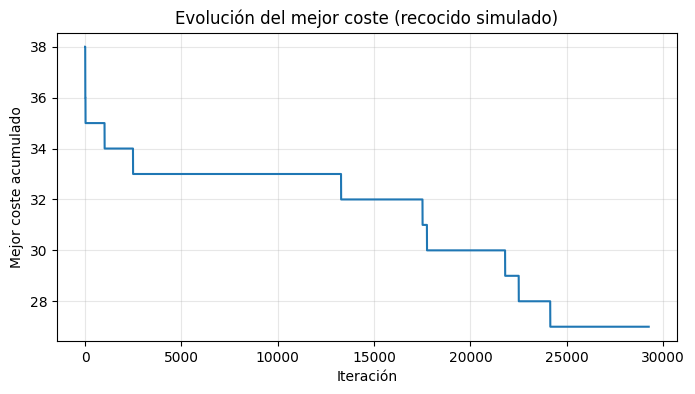

{'espacio_bruto': 931322574615478515625,
 'espacio_con_capacidad': 1370874167589326400,
 'num_niveles': 117,
 'iter_totales': 29250,
 'complejidad_coste': 'O(n*m)',
 'complejidad_vecino': 'O(1) (swap)',
 'complejidad_recocido': 'O(iter_totales * n * m)'}

In [6]:
n = NUM_TOMAS          # tomas
m = NUM_ACTORES        # actores
D = NUM_DIAS           # días (5)
C = MAX_TOMAS_DIA      # capacidad por día (6)

# Tamaño del espacio (sin restricciones): cada toma puede ir a cualquiera de los D días
espacio_bruto = D ** n

# Tamaño de asignaciones con 5 días de 6 tomas (días etiquetados)
espacio_con_capacidad = math.factorial(n) // (math.factorial(C) ** D)

iter_por_temp = PARAMS_RS["iter_por_temp"]
T0 = PARAMS_RS["temp_ini"]
Tf = PARAMS_RS["temp_fin"]
alpha = PARAMS_RS["alpha"]
num_niveles = math.ceil(math.log(Tf / T0) / math.log(alpha))
iter_totales = num_niveles * iter_por_temp

analisis_resumen = {
    "espacio_bruto": espacio_bruto,
    "espacio_con_capacidad": espacio_con_capacidad,
    "num_niveles": num_niveles,
    "iter_totales": iter_totales,
    "complejidad_coste": "O(n*m)",
    "complejidad_vecino": "O(1) (swap)",
    "complejidad_recocido": "O(iter_totales * n * m)",
}

plt.figure(figsize=(8, 4))
plt.plot(historial_mejor)
plt.title("Evolución del mejor coste (recocido simulado)")
plt.xlabel("Iteración")
plt.ylabel("Mejor coste acumulado")
plt.grid(True, alpha=0.3)
plt.show()

analisis_resumen

# Diseño
- ¿Que técnica utilizo? ¿Por qué?


**Técnica elegida:** recocido simulado.
- Parte de una solución inicial simple y factible.
- Explora vecinos por intercambio o movimiento de tomas.
- Minimiza actor-días, que coincide con el coste del problema.
- Respeta la restricción de máximo 6 tomas por día.
- Acepta empeoramientos temporales para escapar de óptimos locales.

## Conclusión e interpretación final

### Modelo
- El espacio de soluciones se representa como una asignación de las 30 tomas en 5 días, con la restricción de no superar 6 tomas por día.
- La función objetivo minimiza actor-días: para cada día se cuentan actores únicos presentes y se suman entre días.
- Como 30 tomas y 5 días obligan a tener 6 tomas por día, el vecindario natural es por intercambio entre días.

### Análisis
- El espacio de búsqueda sigue siendo muy grande, incluso con capacidad fija.
- Evaluar una solución es eficiente para este tamaño de datos ($O(n\cdot m)$).
- La gráfica de convergencia muestra cómo el mejor coste va bajando y luego se estabiliza, señal de convergencia práctica.

### Diseño
- Se usa recocido simulado con solución inicial simple (orden natural de tomas).
- El vecindario se define con `swap` de tomas entre días, coherente con las restricciones del problema.
- Esta técnica permite escapar de óptimos locales al principio y estabilizarse al final.